# mapping-challenge-mask_rcnn-prediction-submission
![CrowdAI-Logo](https://github.com/crowdAI/crowdai/raw/master/app/assets/images/misc/crowdai-logo-smile.svg?sanitize=true)

This notebook contains the code for making predictions from the model trained in [Training.ipynb](Training.ipynb) (or by using the [released pretrained model](https://www.crowdai.org/challenges/mapping-challenge/dataset_files)) for the [crowdAI Mapping Challenge](https://www.crowdai.org/challenges/mapping-challenge).

This code is adapted from the [Mask RCNN]() tensorflow implementation available here : [https://github.com/matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN).

First we begin by importing all the necessary dependencies : 

In [1]:
!pip install tqdm==4.19.9
!pip install shapely
!pip install imutils

    100% |################################| 61kB 528kB/s ta 0:00:01
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 1.0MB 15.7MB/s ta 0:00:01
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for imutils ... done
  Stored in directory: /root/.cache/pip/wheels/db/23/45/fc7424906880ffa9577a2a428b961f2b79e0e21d9f71e7e6bc
Successfully built imutils
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import cv2
import math
import os
import sys
import time
import numpy as np
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import label, regionprops

from scipy.spatial import distance

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import coco #a slightly modified version

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import MappingChallengeDataset
from mrcnn import visualize


import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random
from matplotlib import pyplot as plt
import imutils

import shapely
from shapely.geometry import LineString, Point
ROOT_DIR = os.getcwd()

Using TensorFlow backend.


## Dataset location 
Now we expect that you have downloaded all the files in the datasets section and untar-ed them to have the following structure :
```
├── data
|   ├── pretrained_weights.h5 (already included in this repository)
│   ├── test
│   │   └── images/
│   │   └── annotation.json
│   ├── train
│   │   └── images/
│   │   └── annotation.json
│   └── val
│       └── images/
│       └── annotation.json
```

In [3]:
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "data", "test", "images")

# Instantitate Inference Config

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    IMAGES_PER_GPU = 1
    
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1
    
    BACKBONE = "resnet50"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # 1 Backgroun + 1 Building

    STEPS_PER_EPOCH=1000
    VALIDATION_STEPS=50
    
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               50
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE 

# Instantiate Model

In [5]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = PRETRAINED_MODEL_PATH

# or if you want to use the latest trained model, you can use : 
# model_path = model.find_last()[1]

model.load_weights(model_path, by_name=True)


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


# Run Prediction on a single Image (and visualize results)

In [6]:
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building

(256, 512, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -104.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


NameError: name 'removeBoundaryPredicitions' is not defined

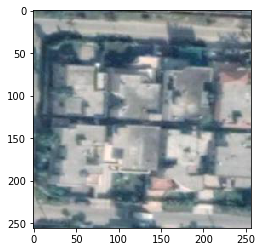

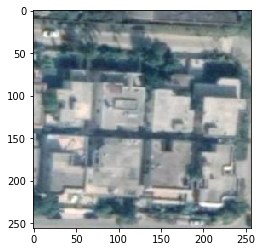

In [7]:
#extracting building blocks

image = skimage.io.imread(os.path.join(ROOT_DIR, "data", "test_data/block2.jpg"))

result = skimage.io.imread(os.path.join(ROOT_DIR, "results", "result2.jpg"))

print(image.shape)

# plt.figure()
# plt.imshow(image)


patch = image[0:256, 0:256]
patch2 = image[0:256, 256:512]

patches = [patch, patch2]


# patch = image[0:256, 320:576]

plt.figure()
plt.imshow(patch)

plt.figure()
plt.imshow(patch2)

total_width = 0
total_length = 0
angles = []
total_masks = 0

for patch in patches:
    predictions = model.detect([patch]*config.BATCH_SIZE, verbose=1)

    p = predictions[0]
    p = removeBoundaryPredicitions(p)

    total_masks += p['masks'].shape[2]

    for i in range(p['masks'].shape[2]):
        mask_img = p['masks'][:, :, i]
        mask_img = label(mask_img, connectivity=mask_img.ndim)
        regions = regionprops(mask_img)
        degrees = math.degrees(regions[0].orientation)
        angles.append(degrees)

        plt.figure()

        fig, ax = plt.subplots()
        ax.imshow(mask_img, cmap=plt.cm.gray)

        for props in regions:
            y0, x0 = props.centroid
            orientation = props.orientation
            x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

            ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
            ax.plot(x0, y0, '.g', markersize=15)

            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax.plot(bx, by, '-b', linewidth=2.5)
            
            minr, minc, maxr, maxc = props.bbox

            total_width += (maxc - minc)
            total_length += (maxr - minr)
            
        
        print("Angle: ")
        print(degrees)
        ax.axis((0, 256, 256, 0))
        plt.show()
        
        
average_width = total_width/int(total_masks)
print("Average Width: ")
print(average_width)

print("Average Length: ")
print(total_length/int(total_masks))

print("Angles: ")
print(angles)



Processing 1 images
image                    shape: (256, 256, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -104.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
((54.29160690307617, 92.2105941772461), (59.24863815307617, 65.2734603881836), -88.45184326171875)
[[ 86.116066 122.70586 ]
 [ 20.866425 120.94235 ]
 [ 22.467148  61.715332]
 [ 87.71679   63.478836]]
-37.00016
893.0034


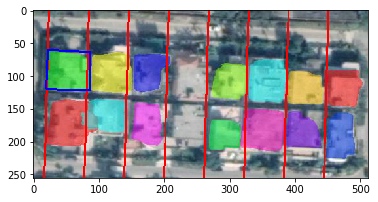

In [117]:
#min area rectangle
# image = skimage.io.imread(os.path.join(ROOT_DIR, "data", "block_zoom_20.jpg"))
image = skimage.io.imread(os.path.join(ROOT_DIR, "data", "test_data/block2.jpg"))
result = skimage.io.imread(os.path.join(ROOT_DIR, "results", "result2.jpg"))

shape = image.shape
imgheight=image.shape[0]
imgwidth=image.shape[1]

M = 256
N = 256

tile1 = image[0:256, 0:256]
tile2 = image[0:256, 256:512]

predictions1 = model.detect([tile1]*config.BATCH_SIZE, verbose=1)
# predictions2 = model.detect([tile2]*config.BATCH_SIZE, verbose=1)


p1 = predictions1[0]
p1 = removeBoundaryPredicitions(p1)












mask_img = p1['masks'][:, :, 1]
# mask_img = mask_img.astype(np.uint8)

mask_img = mask_img.astype(np.uint8)

print(mask_img)

res, contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]

rect = cv2.minAreaRect(cnt)

print(rect)








box = cv2.boxPoints(rect)

print(box)
#finding minor axis gradient
point1 = box[1]
point2 = box[2]

m = (point2[1] - point1[1])/(point2[0] - point1[0])

print(m)
c = point2[1] - (m*point2[0])
print(c)

#we have equation of the line y = mx + c
#now we need the edge points i.e. where y=0 and y=256

y1 = 0
x1 = (((-1*c)/m) if m != 0 else point1[0])
line_point1 = (int(x1), int(y1))

y2 = 256
x2 = (((y2 - c)/m) if m != 0 else point1[0])
line_point2 = (int(x2), int(y2))

cv2.line(result,line_point1,line_point2,(255,0,0),2)

#draw lines repeatedly at a distance of average width

w = 61

while(1):
    line_point1 = list(line_point1)
    new_x1 = line_point1[0] + w
    
    line_point2 = list(line_point2)
    new_x2 = line_point2[0] + w
    
    if(new_x1 >= shape[1] or new_x2 >= shape[1]):
        break
    
    line_point1[0] = new_x1
    line_point2[0] = new_x2
    
    line_point1 = tuple(line_point1)
    line_point2 = tuple(line_point2)
    
    cv2.line(result,line_point1,line_point2,(255,0,0),2)


box = np.int0(box)

cv2.drawContours(result,[box],0,(0,0,255),2)

plt.imshow(result)



In [7]:
# image = skimage.io.imread(os.path.join(ROOT_DIR, "data", "block_zoom_20.jpg"))

# image_sample1 = image[0:256, 256:512]
# predictions = model.detect([image_sample1]*config.BATCH_SIZE, verbose=1)

# p = predictions[0]


def removeBoundaryPredicitions(p):

    temp = {}

    rois = p['rois']
    masks = p['masks']
    class_ids = p['class_ids']
    scores = p['scores']

    remove_indexes = []

    for i in range(len(rois)):

        roi = rois[i]
        leftY = roi[0]
        leftX = roi[1]
        rightY = roi[2]
        rightX = roi[3]

        if(leftY <= 2) or (rightY >= 254) or (leftX <= 2) or (rightX >= 254):
            remove_indexes.append(i)


    temp['rois'] = np.delete(p['rois'], remove_indexes, axis=0)
    temp['masks'] = np.delete(p['masks'], remove_indexes, axis=2)
    temp['class_ids'] = np.delete(p['class_ids'], remove_indexes, axis=0)
    temp['scores'] = np.delete(p['scores'], remove_indexes, axis=0)
    
    return temp

In [ ]:
#Test
image = skimage.io.imread(os.path.join(ROOT_DIR, "data", "block_zoom_20.jpg"))

image_sample = image[0:256,0:1024]

image_sample1 = image_sample[0:256, 0:256]
image_sample2 = image_sample[0:256, 128:384]

img_sum = np.zeros((256, 384, 3))

img_sum[0:256, 0:128] = image_sample1[0:256, 0:128]
img_sum[0:256, 128:256] = image_sample1[0:256, 128:256]*0.5 + image_sample2[0:256, 0:128]*0.5
img_sum[0:256, 256:384] = image_sample2[0:256, 128:256]

print(img_sum.shape)

# sum = (image_sample1[0:256, 0:256] + image_sample2)/2
img_sum = np.uint8(img_sum)

plt.imshow(img_sum)
# skimage.io.imshow(sum)  

In [ ]:
#for partial overlapping windows
def process_image_strip(strip):

    #default parameters
    default_size = 256
    half_size = default_size/2
    window_size = default_size/2
    window_X_start = 0
    window_X_end = default_size

    windows = []
    
    stripX = strip.shape[1]
    
    print("strip shape")
    print(strip.shape)
    print(stripX)
    

    while(window_X_end <= strip.shape[1]):
        window1 = strip[0:256, int(window_X_start):int(window_X_end)]
        windows.append(window1)
        window_X_start += window_size
        window_X_end += window_size

    result = np.zeros((256, stripX, 3))

    prediction = model.detect([windows[0]]*config.BATCH_SIZE, verbose=1)
    p = prediction[0]
    p = removeBoundaryPredicitions(p)

    img = visualize.display_instances(windows[0], p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

    window_X_start = 0
    window_X_end = 256


    result[0:256, int(window_X_start):int(window_X_end)] = img


    i = 1
    
    while(i < len(windows)):

        prediction = model.detect([windows[i]]*config.BATCH_SIZE, verbose=1)
        p = prediction[0]
        p = removeBoundaryPredicitions(p)

        img = visualize.display_instances(windows[i], p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

        result[0:256, int(window_X_end - half_size):int(window_X_end)] = result[0:256, int(window_X_end - half_size):int(window_X_end)]*0.5 + img[0:256, 0:128]*0.5


        result[0:256, int(window_X_end):int(window_X_end + half_size)] = img[0:256, 128:256]
        window_X_end += half_size

        i += 1
    
    return result

In [ ]:
#for partial overlapping windows
image = skimage.io.imread(os.path.join(ROOT_DIR, "data", "block3_zoom_20.jpg"))

print(image.shape)

imageY = image.shape[0]
imageX = image.shape[1]

result = np.zeros((imageY, imageX, 3))

#generate strips
default_size = 256
half_size = default_size/2
strip_size = default_size/2
strip_Y_start = 0
strip_Y_end = default_size

strips = []

while(strip_Y_end <= imageY):
    strip1 = image[int(strip_Y_start):int(strip_Y_end), 0:int(imageX)]
    strips.append(strip1)
    strip_Y_start += strip_size
    strip_Y_end += strip_size
    

strip_Y_start = 0
strip_Y_end = 256

strip_result = process_image_strip(strips[0])
result[int(strip_Y_start):int(strip_Y_end), 0:int(imageX)] = strip_result
    
i = 1
while(i < len(strips)):
    
    strip_result = process_image_strip(strips[i])
    
    result[int(strip_Y_end - half_size):int(strip_Y_end), 0:int(imageX)] = result[int(strip_Y_end - half_size):int(strip_Y_end), 0:int(imageX)]*0.5 + strip_result[0:128, 0:int(imageX)]*0.5

    result[int(strip_Y_end):int(strip_Y_end + half_size), 0:int(imageX)] = strip_result[128:256, 0:int(imageX)]
    strip_Y_end += half_size
    
    print("Strip Added")
    
    plt.figure()
    plt.imshow(result)
    
    i += 1


result = np.uint8(result)

plt.figure()
plt.imshow(result)

skimage.io.imsave('./final3.jpg', result)
    
    

In [ ]:
#Test
image = skimage.io.imread(os.path.join(ROOT_DIR, "data", "block_zoom_20.jpg"))

imgheight=image.shape[0]
imgwidth=image.shape[1]

new_image = np.zeros((imgheight, imgwidth, 3))

tile = image[256:512,256:512]

predictions = model.detect([tile]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

p = predictions[0]

M = 256
N = 256
    
img = visualize.display_instances(tile, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

image_resized = resize(img, (256, 256))

print(image_resized.shape[0])
print(image_resized.shape[1])

skimage.io.imshow(image_resized)  

In [ ]:
image = skimage.io.imread(os.path.join(ROOT_DIR, "data", "block3_zoom_20.jpg"))

imgheight=image.shape[0]
imgwidth=image.shape[1]

new_image = np.zeros((imgheight, imgwidth, 3))

tile = image[128:384,0:256]

predictions = model.detect([tile]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

p = predictions[0]

M = 256
N = 256
    
img = visualize.display_instances(tile, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

image_resized = resize(img, (256, 256))

print(image_resized.shape[0])
print(image_resized.shape[1])

skimage.io.imshow(image_resized)     


In [ ]:
from PIL import Image

im = Image.open("./data/test_data/block9.png")
rgb_im = im.convert('RGB')
rgb_im.save('./data/test_data/block9.jpg')
os.remove("./data/test_data/block9.png")

256
512
0
(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
256
(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


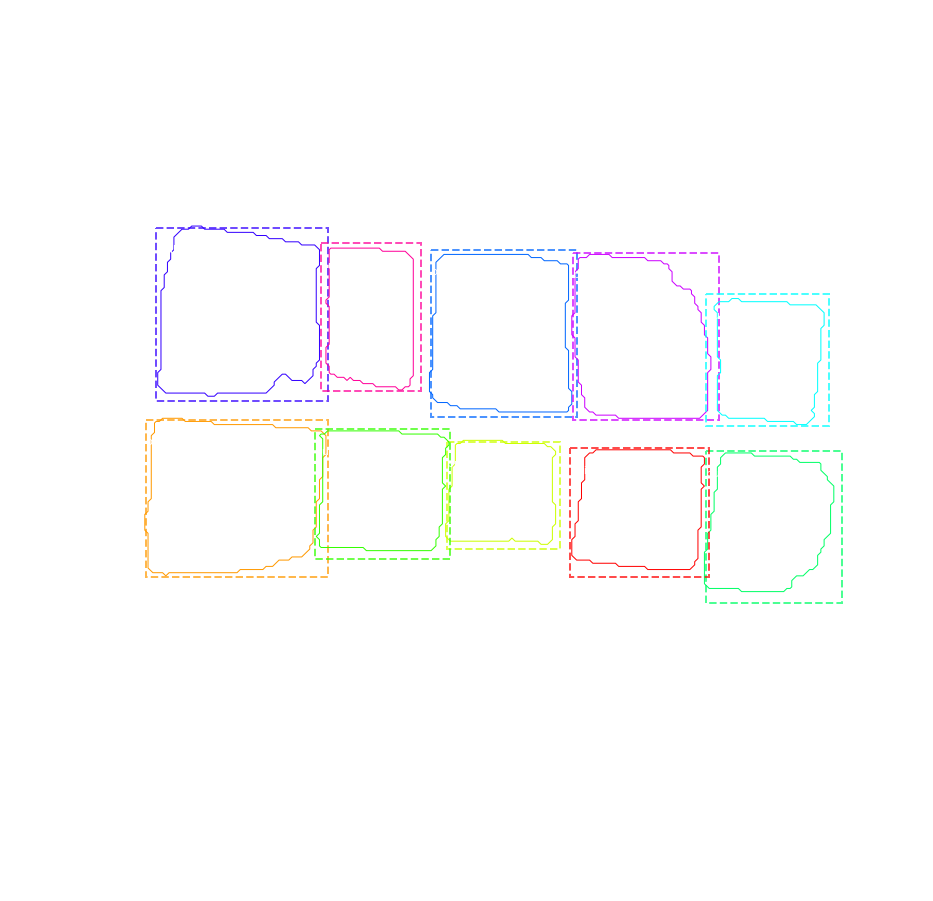

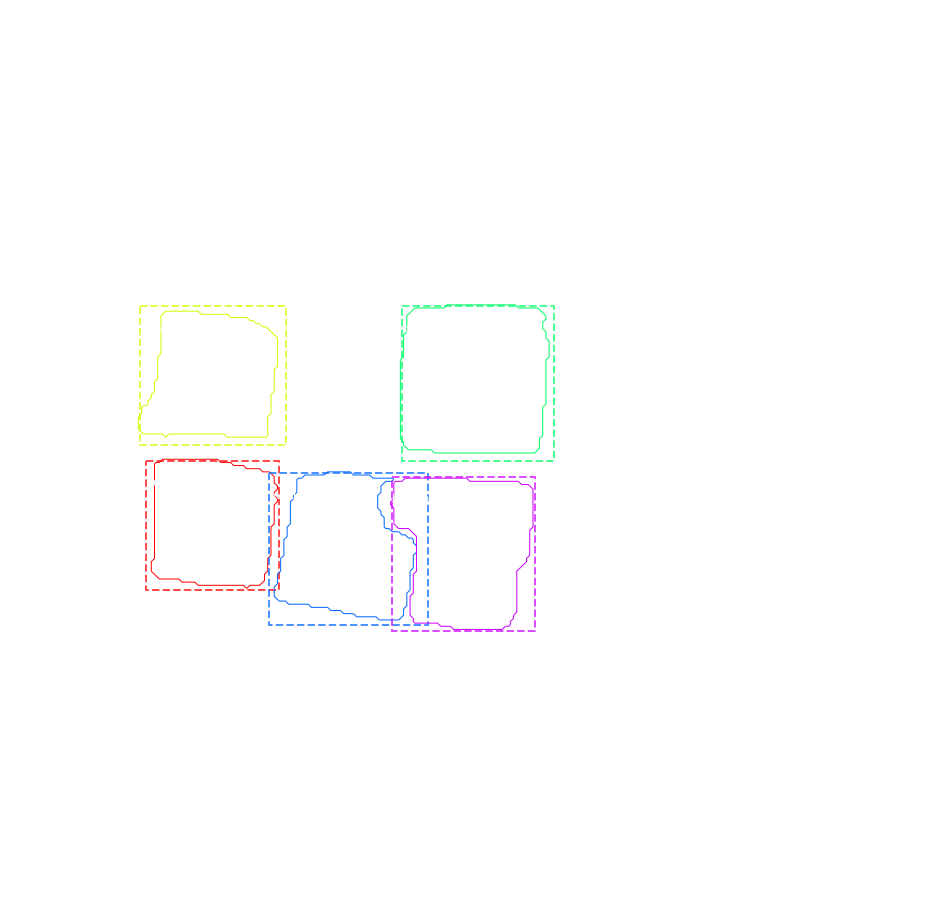

In [58]:
#create tiles of 256x256 from the image, run predictions on all tiles, and join them in result
ROOT_DIR = os.getcwd()

image = skimage.io.imread("./data/test_data/block6c.jpg")

imgheight=image.shape[0]
imgwidth=image.shape[1]

print(imgheight)
print(imgwidth)

new_image = np.zeros((imgheight, imgwidth, 3))

M = 256
N = 256


for y in range(0,imgheight,M):
    for x in range(0, imgwidth, N):
        y1 = y + M
        x1 = x + N
        
        tile = image[y:y+M,x:x+N]
        
        print(x)
        print(tile.shape)
        
        predictions = model.detect([tile]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

        p = predictions[0]
        p = removeBoundaryPredicitions(p)
        
        img = visualize.display_instances(tile, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])
        
        image_resized = resize(img, (256, 256))
        
        new_image[y:y+M,x:x+N] = image_resized
        
skimage.io.imsave('./results/result6c.jpg', new_image)

# Run detection on rotated image

In [8]:
def roundToNearestPowerOf2(val):
    result = 0
    
    prev_diff = val - result
    
    while(1):
        result += 256
        diff = val - result
        if(diff < 0):
            diff = -1*diff
        
        if diff < prev_diff:
            prev_diff = diff
        else:
            result -= 256
            break
        
    
    return result

In [9]:
def getImageData(image, file_name):
    imgheight=roundToNearestPowerOf2(image.shape[0])
    imgwidth=roundToNearestPowerOf2(image.shape[1])

    M = 256
    N = 256
    
    total_width = 0
    total_length = 0
    total_masks = 0
    masks = []
    
    new_image = np.zeros((imgheight, imgwidth, 3))

    for y in range(0, imgheight, M):
        for x in range(0, imgwidth, N):
            patch = image[y:y+M,x:x+N]

            predictions = model.detect([patch]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

            p = predictions[0]
            p = removeBoundaryPredicitions(p)
            
            img = visualize.display_instances(patch, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])
            image_resized = resize(img, (256, 256))
            new_image[y:y+M,x:x+N] = image_resized

            for i in range(p['masks'].shape[2]):
                mask = p['masks'][:, :, i]
                
                #get minimum enclosing rectangle for mask
                mask_img = mask.astype(np.uint8)
                res, contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                
                if contours:
                    total_masks += 1
                    
                    cnt = contours[0]
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)

                    for i in range(len(box)):
                        box[i][0] = box[i][0] + x
                        box[i][1] = box[i][1] + y

                    masks.append(box)

                    mask_img = label(mask, connectivity=mask_img.ndim)
                    regions = regionprops(mask_img)

                    for props in regions:
                        minr, minc, maxr, maxc = props.bbox

                        total_width += (maxc - minc)
                        total_length += (maxr - minr)
    plt.figure()
    plt.imshow(image)
    
    skimage.io.imsave("./rotated_results/"+file_name+".jpg", new_image)

    return total_width/int(total_masks), total_length/int(total_masks), masks, new_image

# Processing for rectangular shaped blocks

In [10]:
def rotate_box(bb, cx, cy, h, w, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        # compute the new bounding dimensions of the image
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        # adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - cx
        M[1, 2] += (nH / 2) - cy
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

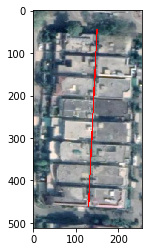

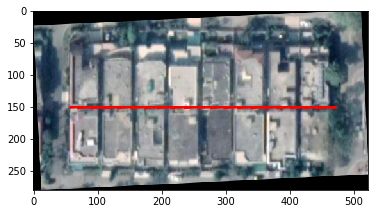

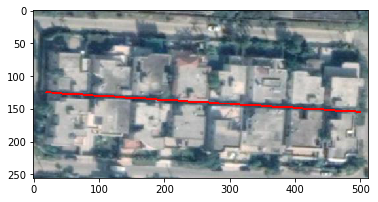

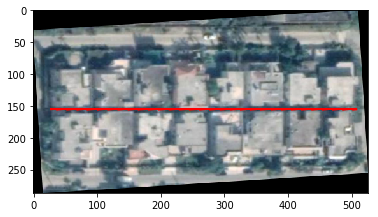

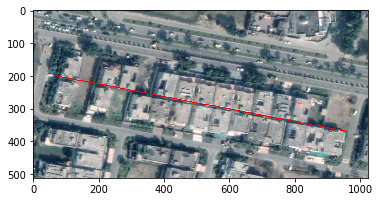

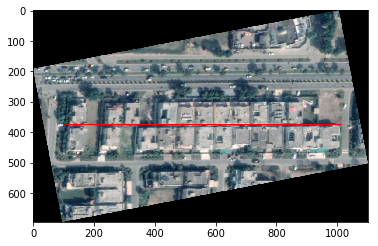

In [21]:
def findRotationAngle(image, a, b):

    def distance(p1, p2):
        return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))
    
    line_length = distance(a, b)
    shape = image.shape
    
    r_a = a
    r_b = (a[0] + line_length, a[1])
    
    l1 = [a, b]
    l2 = [r_a, r_b]
    
    m1 = (b[1] - a[1])/(b[0] - a[0])
    m2 = (r_b[1] - r_a[1])/(r_b[0] - r_a[0])

    angle1 = math.atan(m1)
    angle2 = math.atan(m2)
    
    angle_deg = (angle2-angle1)*180/math.pi
    
    return angle_deg


def getRotatedImageAndDividingLine(img_org, a, b):
    theta = findRotationAngle(img_org, a, b)

    rotated_img = rotate_bound(img_org, -1*theta)

    plt.figure()
    plt.imshow(rotated_img)

    heigth, width = img_org.shape[:2]
    (cx, cy) = (width // 2, heigth // 2)

    bb1 = {}
    bb1[0] = [a, b]

    new_bb = {}
    for i in bb1:
        new_bb[i] = rotate_box(bb1[i], cx, cy, heigth, width, -1*theta)

    r_a = (int(new_bb[0][0][0]), int(new_bb[0][0][1]))
    r_b = (int(new_bb[0][1][0]), int(new_bb[0][1][1]))
    
    return rotated_img, r_a, r_b


img_org = skimage.io.imread("./data/test_Data/block1.jpg")

a = (150, 45)
b = (130, 460)
    
cv2.line(img_org,a,b,(255,0,0),2)
r_image, r_a, r_b = getRotatedImageAndDividingLine(img_org, a, b)
cv2.line(r_image,r_a,r_b,(255,0,0),2)

plt.imshow(img_org)
plt.figure()
plt.imshow(r_image)

skimage.io.imsave('./block1.jpg', img_org)
skimage.io.imsave('./block1_r.jpg', r_image)


img_org = skimage.io.imread("./data/test_Data/block2.jpg")

a = (20, 125)
b = (500, 155)

cv2.line(img_org,a,b,(255,0,0),2)
r_image, r_a, r_b = getRotatedImageAndDividingLine(img_org, a, b)
cv2.line(r_image,r_a,r_b,(255,0,0),2)

plt.imshow(img_org)
plt.figure()
plt.imshow(r_image)

skimage.io.imsave('./block2.jpg', img_org)
skimage.io.imsave('./block2_r.jpg', r_image)


img_org = skimage.io.imread("./data/test_Data/block3.jpg")

a = (70, 200)
b = (960, 370)

cv2.line(img_org,a,b,(255,0,0),2)
r_image, r_a, r_b = getRotatedImageAndDividingLine(img_org, a, b)
cv2.line(r_image,r_a,r_b,(255,0,0),2)

plt.imshow(img_org)
plt.figure()
plt.imshow(r_image)

skimage.io.imsave('./block3.jpg', img_org)
skimage.io.imsave('./block3_r.jpg', r_image)


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32

*** No instances to display *** 

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32

*** No instances to display *** 

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_image

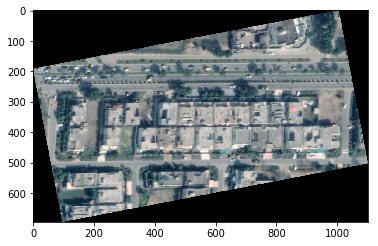

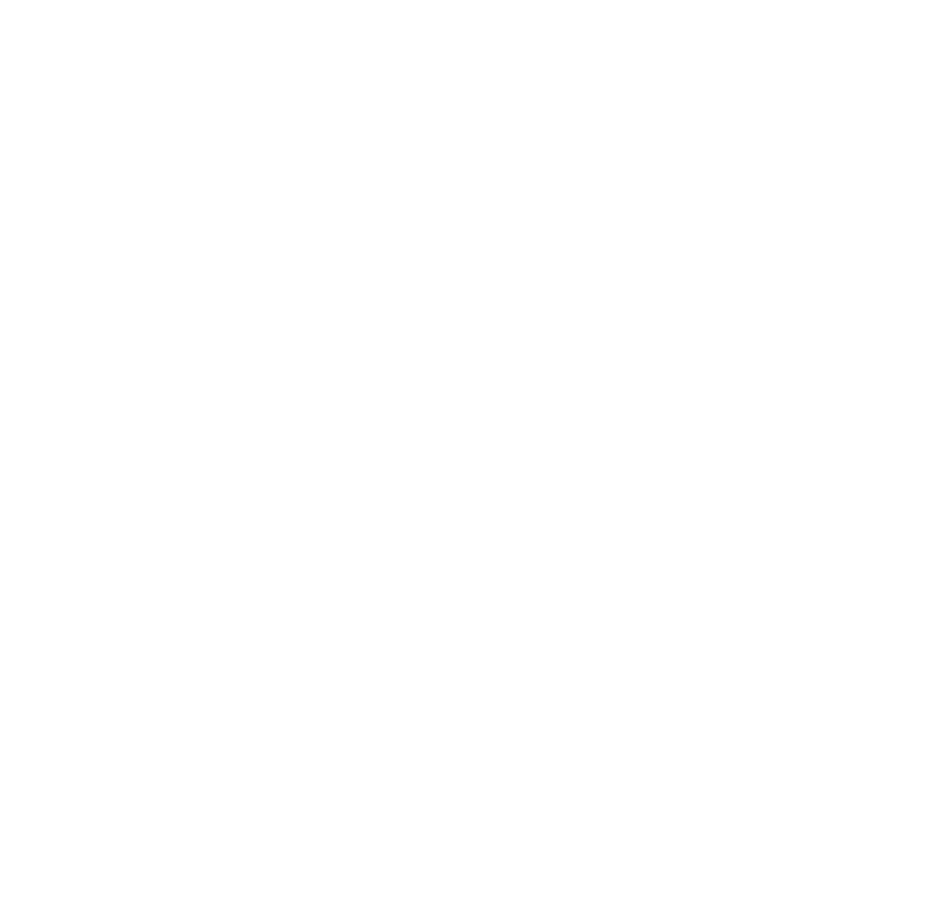

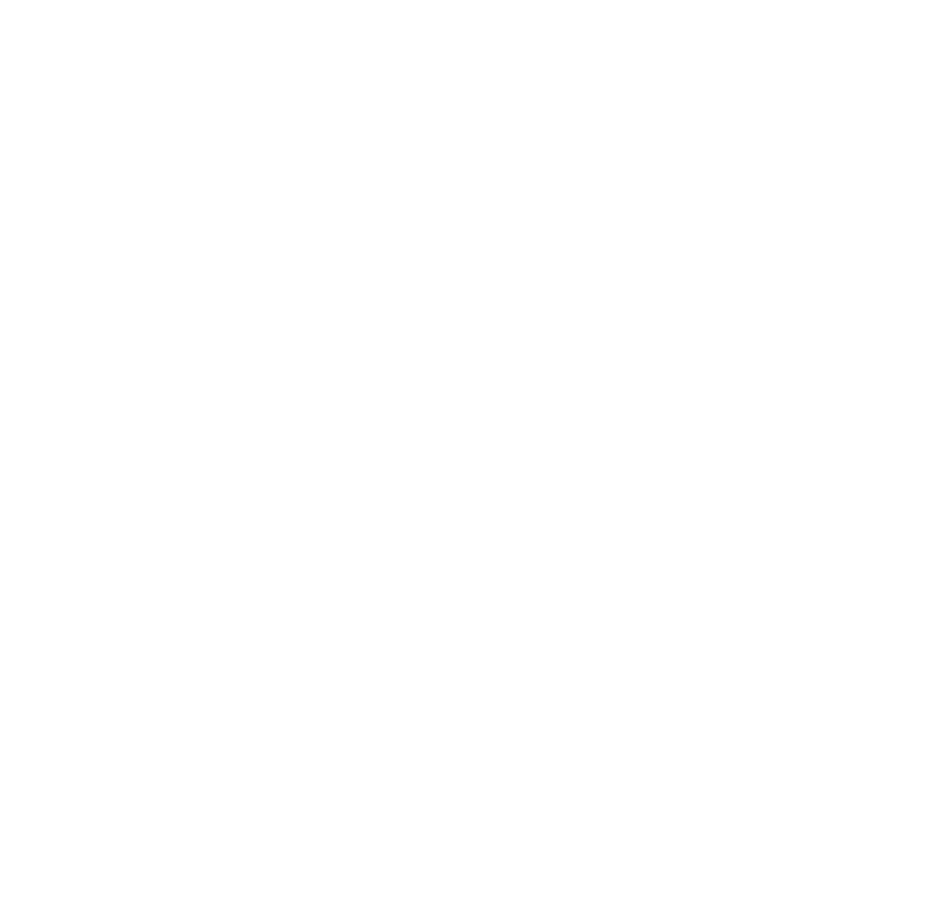

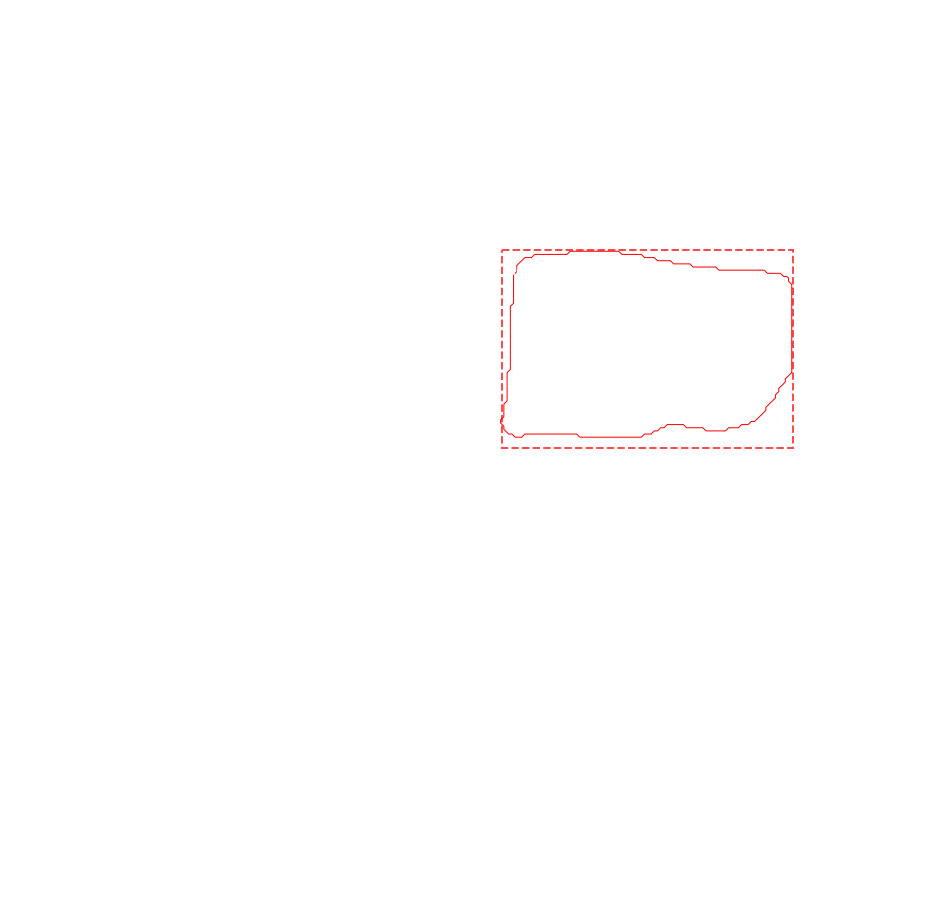

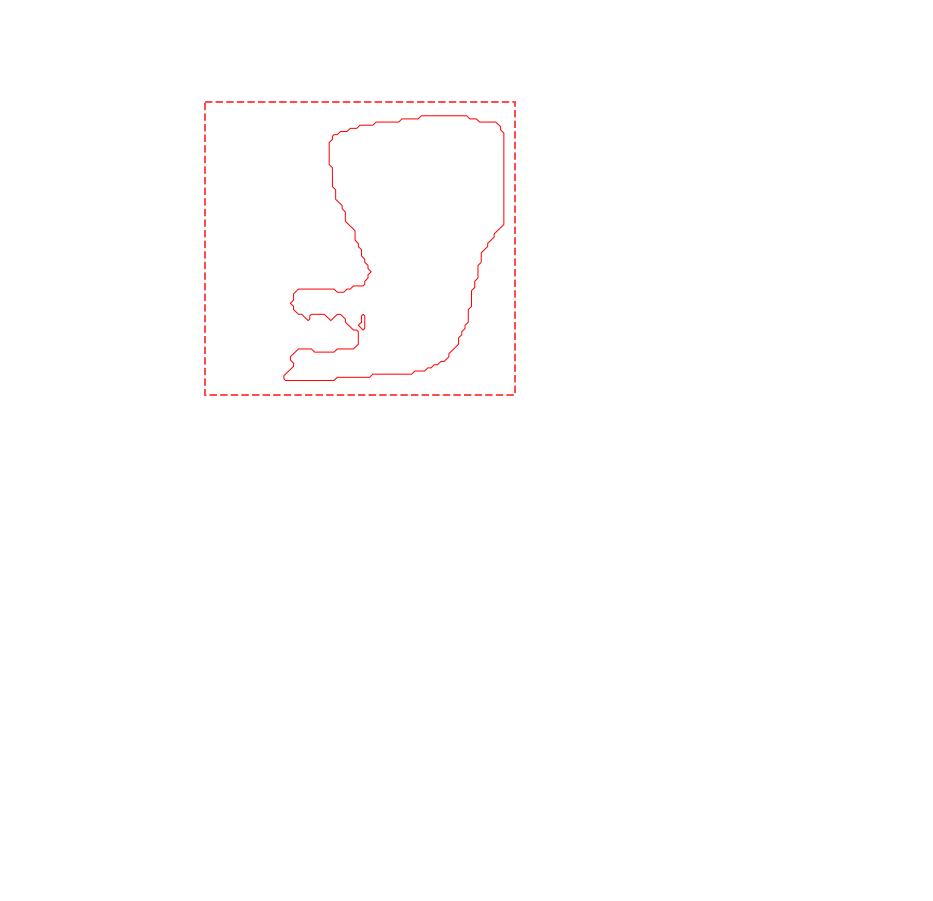

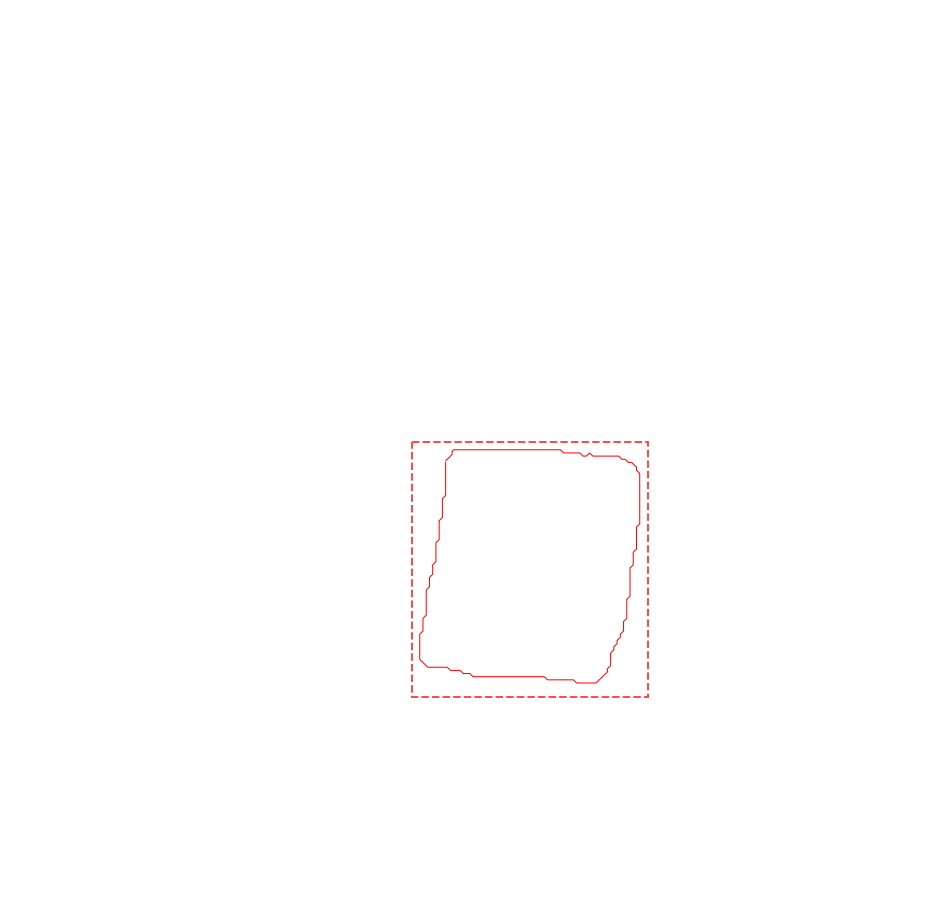

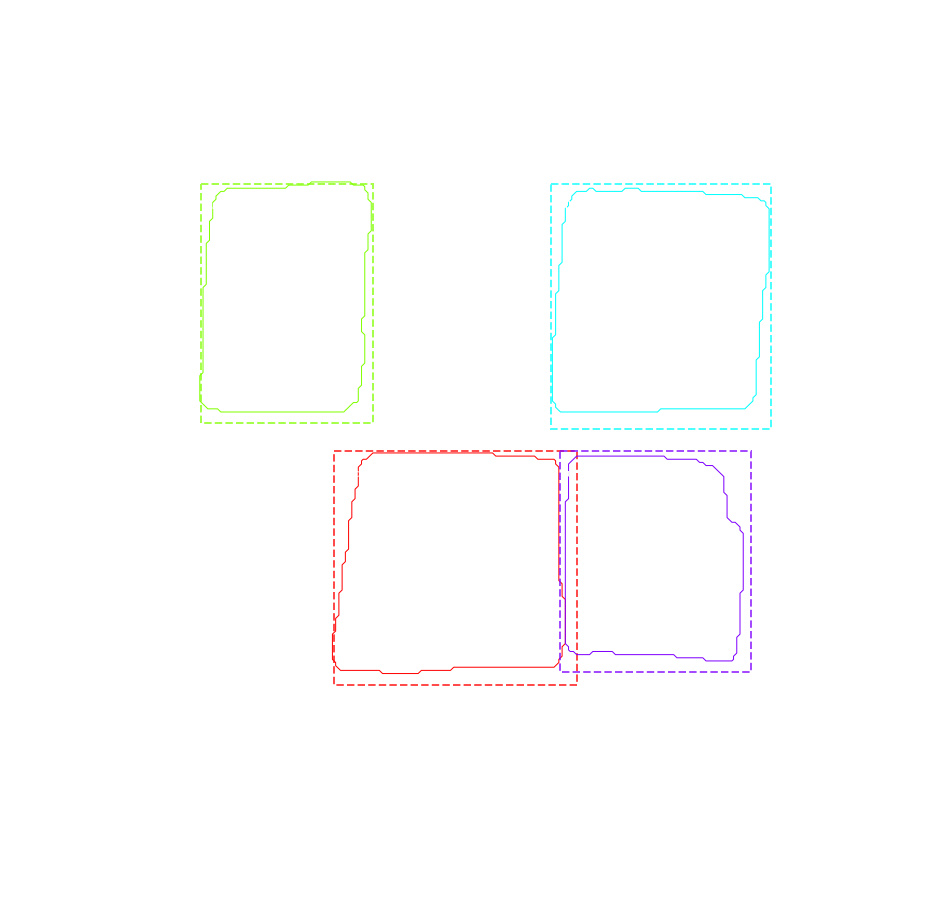

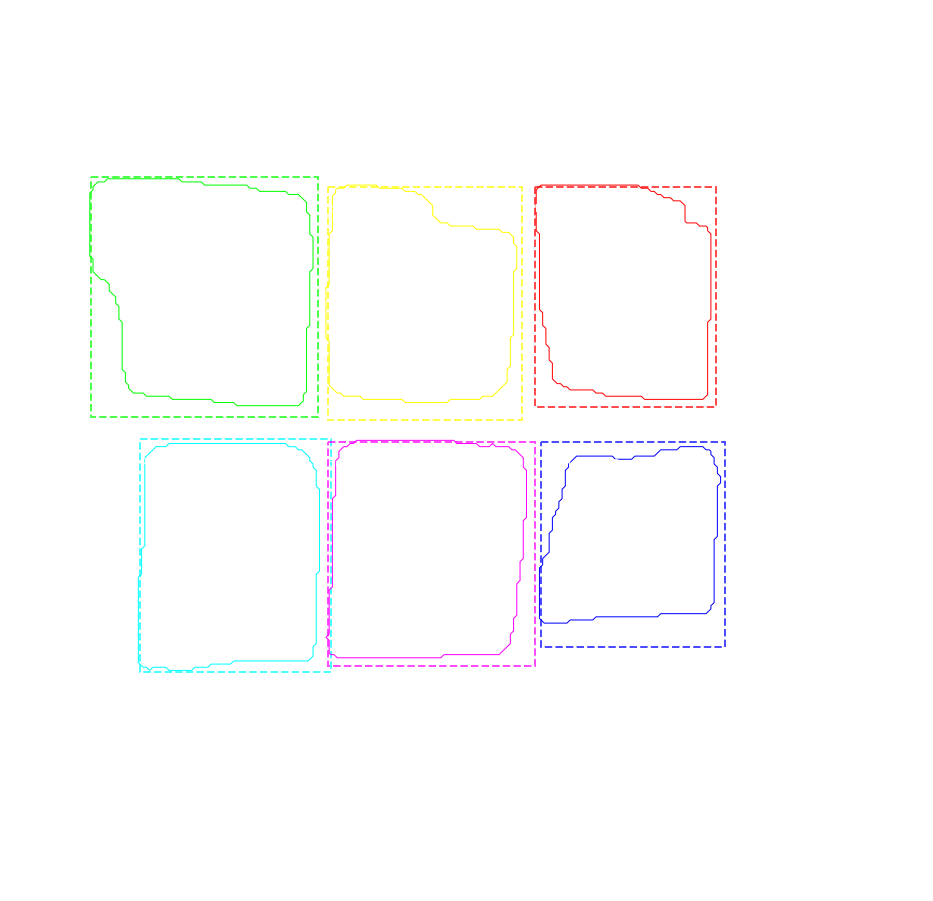

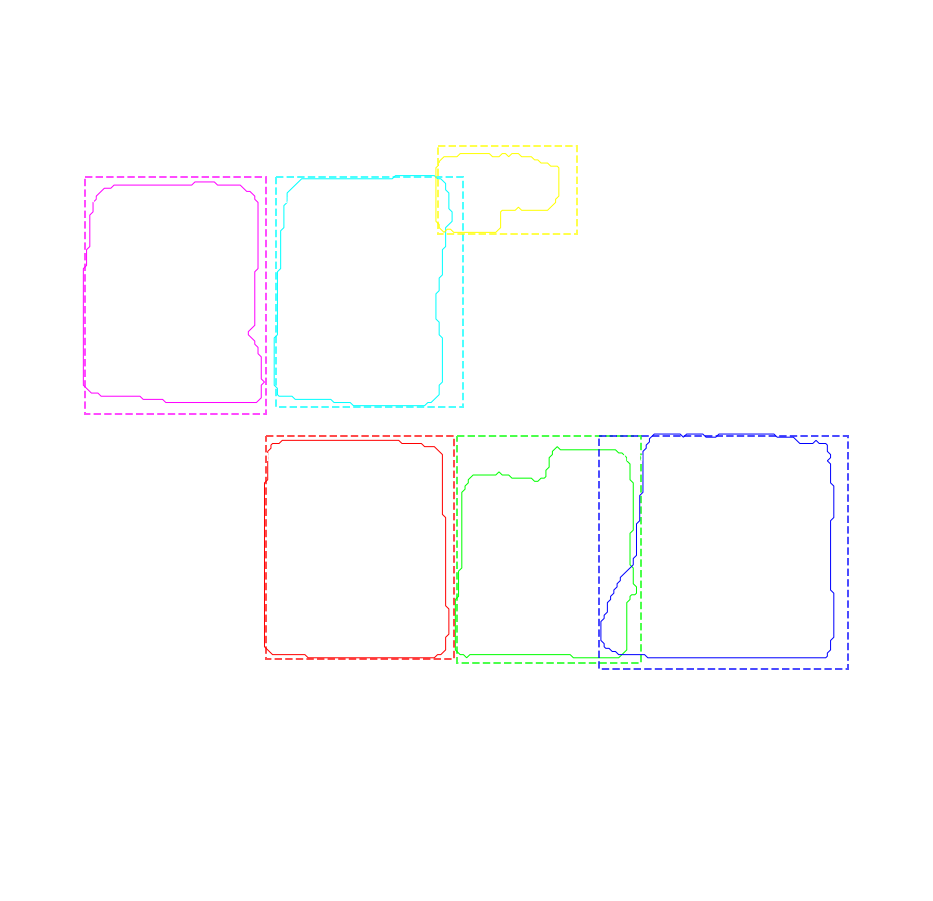

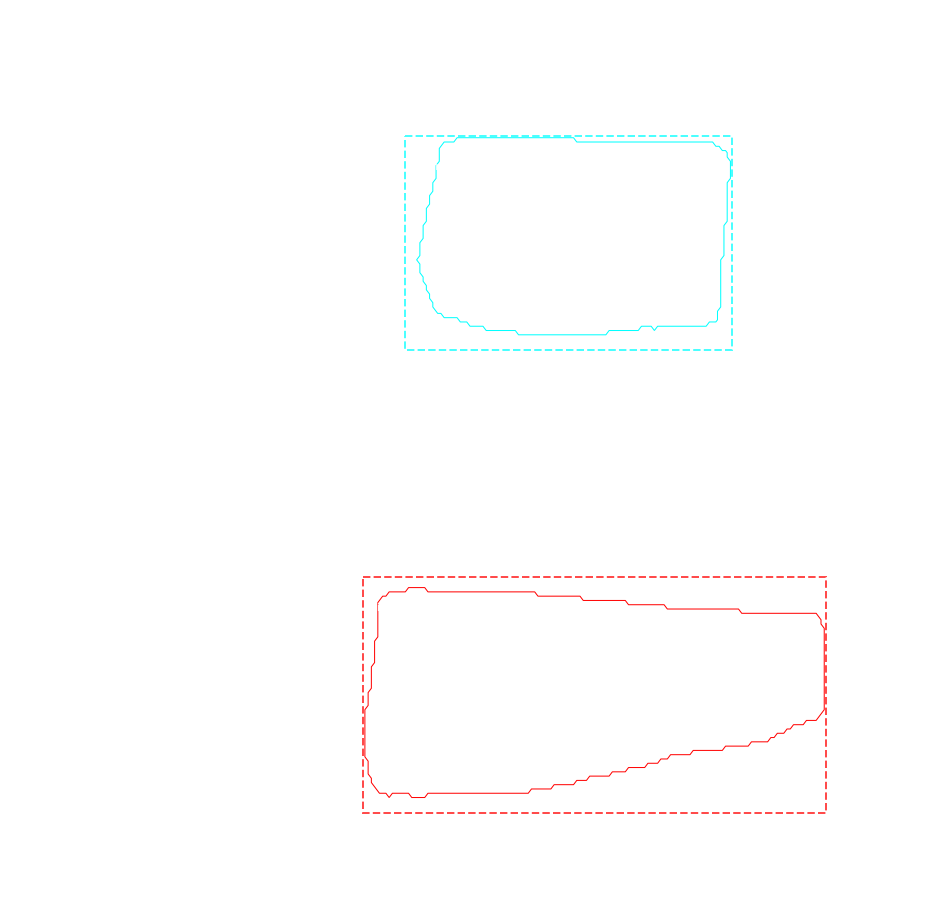

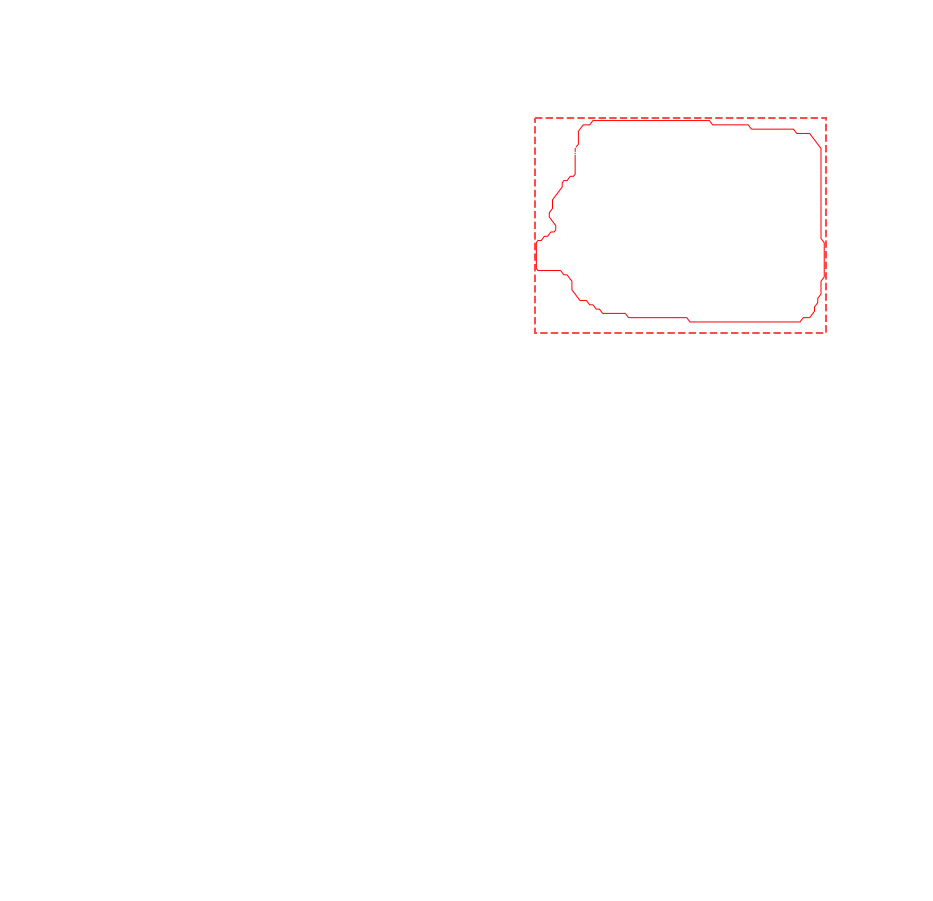

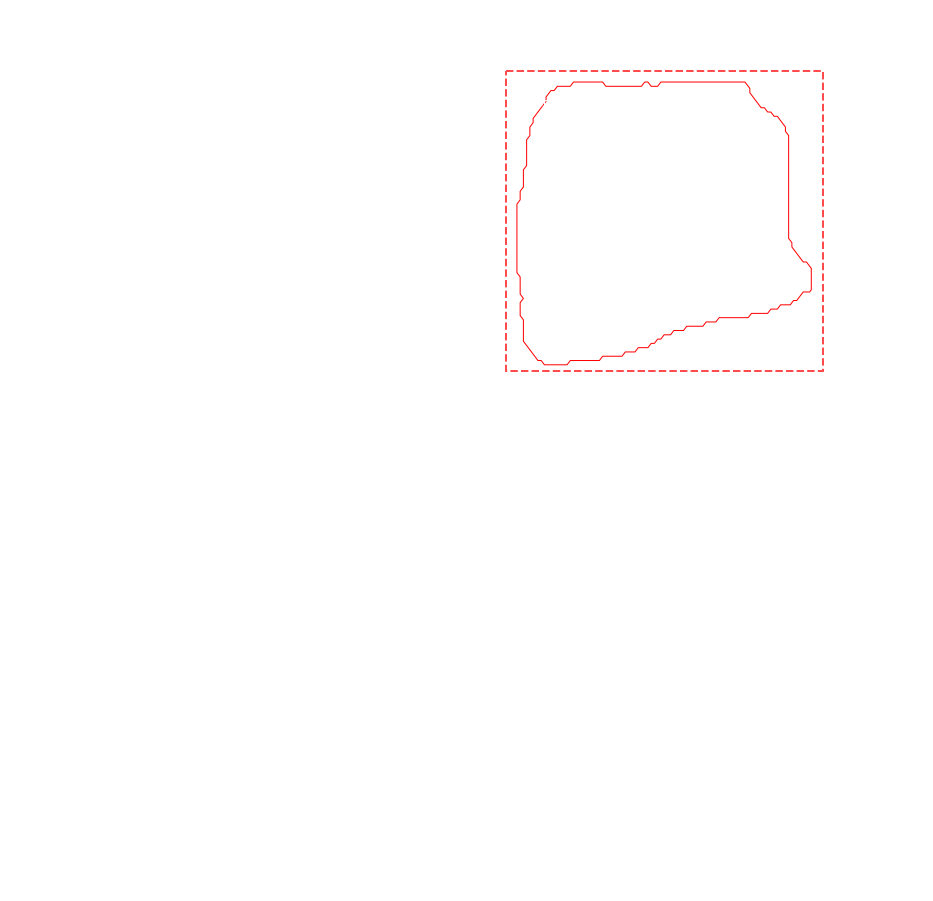

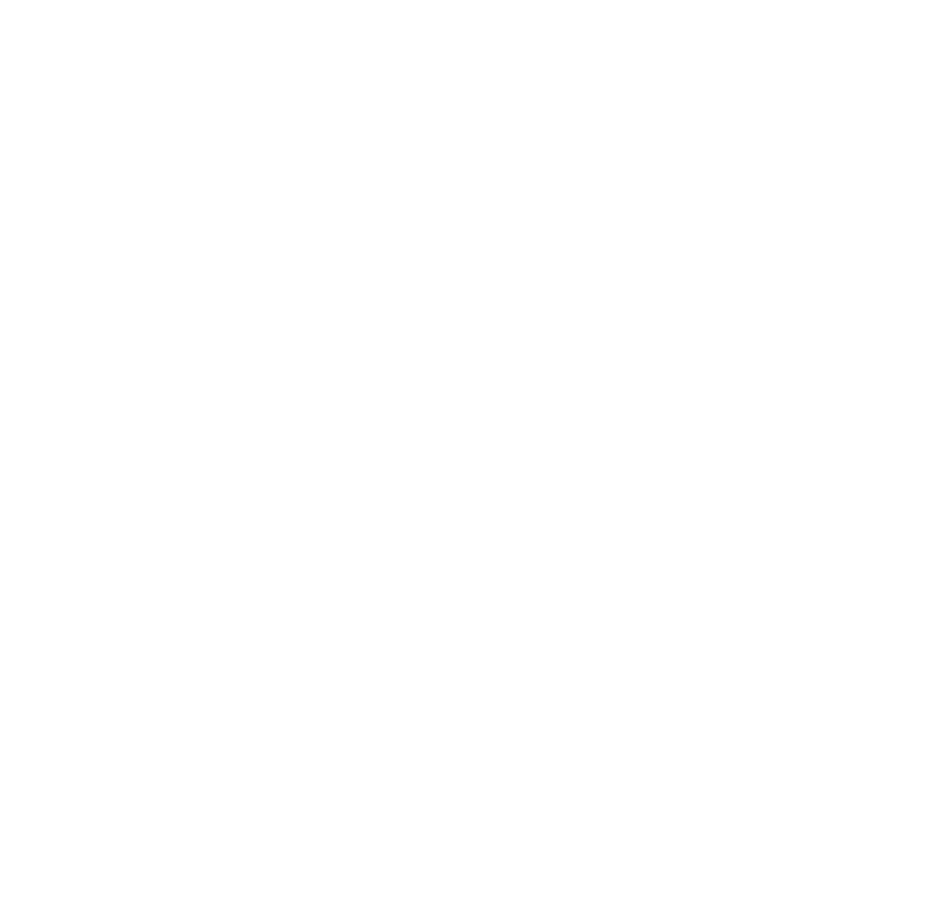

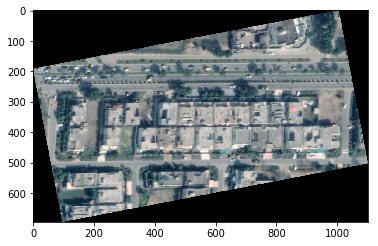

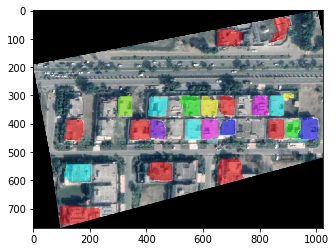

In [82]:
file_name = 'block3'

img_org = skimage.io.imread("./data/test_Data/"+ file_name +".jpg")

a = (70, 200)
b = (960, 370)

r_image, a, b = getRotatedImageAndDividingLine(img_org, a, b)
w, l, masks, r_image = getImageData(r_image, file_name)

plt.figure()
plt.imshow(r_image)

image = skimage.io.imread("./rotated_results/block3.jpg")
image2 = skimage.io.imread("./rotated_results/block3.jpg")

shape = image.shape

def distance(p1, p2):
    return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

block_length = distance(a, b)
total_divisions = int(round(block_length/int(w)))

cd_length = int(l*2.3)

ab = LineString([a, b])
left = ab.parallel_offset(cd_length / 2, 'left')
right = ab.parallel_offset(cd_length / 2, 'right')

c = left.boundary[1]
d = right.boundary[0]  # note the different orientation for right offset
cd = LineString([c, d])

c = (int(c.x), int(c.y))
d = (int(d.x), int(d.y))

cv2.line(image,a,b,(0,255,0),2)
cv2.line(image,c,d,(255,0,0),2)

cv2.line(image2,a,b,(0,255,0),2)
cv2.line(image2,c,d,(255,0,0),2)

drawMasks(image, masks)
cost = getParallelLinesAndCost(image, int(w), c, d, total_divisions, masks)

print("Cost before line adjustment: ")
print(cost)

plt.figure()
plt.imshow(image)

cost = getAdjustedParallelLinesAndCost(image2, int(w), c, d, total_divisions, masks)
print("Cost After line adjustment: ")
print(cost)

plt.figure()
plt.imshow(image2)

Cost before line adjustment: 
278
Cost After line adjustment: 
(42, 63.25)


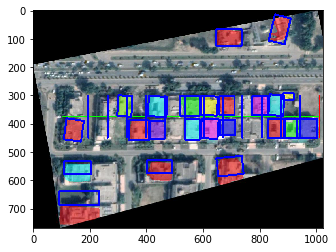

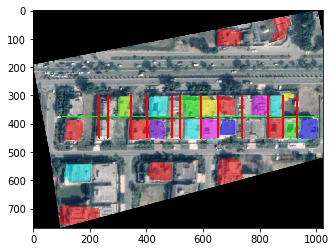

In [92]:
image = skimage.io.imread("./rotated_results/block3.jpg")
image2 = skimage.io.imread("./rotated_results/block3.jpg")

shape = image.shape

def distance(p1, p2):
    return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

block_length = distance(a, b)
total_divisions = int(round(block_length/int(w)))

cd_length = int(l*2.3)

ab = LineString([a, b])
left = ab.parallel_offset(cd_length / 2, 'left')
right = ab.parallel_offset(cd_length / 2, 'right')

c = left.boundary[1]
d = right.boundary[0]  # note the different orientation for right offset
cd = LineString([c, d])

c = (int(c.x), int(c.y))
d = (int(d.x), int(d.y))

cv2.line(image,a,b,(0,255,0),2)
cv2.line(image,c,d,(255,0,0),2)

cv2.line(image2,a,b,(0,255,0),2)
cv2.line(image2,c,d,(255,0,0),2)

drawMasks(image, masks)
cost = getParallelLinesAndCost(image, int(w), c, d, total_divisions, masks)

print("Cost before line adjustment: ")
print(cost)

plt.figure()
plt.imshow(image)

cost = getAdjustedParallelLinesAndCost(image2, int(w), c, d, total_divisions, masks)
print("Cost After line adjustment: ")
print(cost)

plt.figure()
plt.imshow(image2)


256
512
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


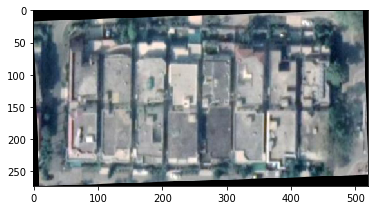

In [22]:
w, l, masks, image = getImageData('block1', 88)

Average Width:
42
Cost before line adjustment: 
134
(412, 244)
(365, 244)
(309, 244)
(265, 244)
(210, 244)
(168, 244)
(107, 244)
(55, 244)
(13, 244)
Total Gap Between Lines: 
447
Cost After line adjustment: 
0
Average Gap
49
Cost with average gap: 
45


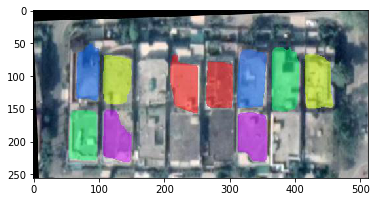

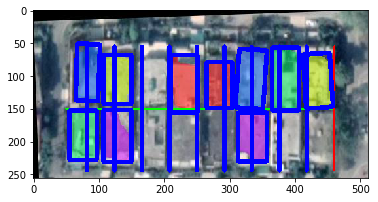

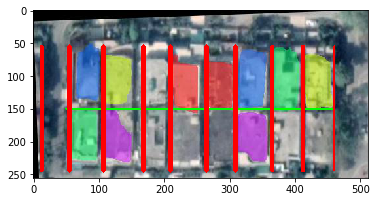

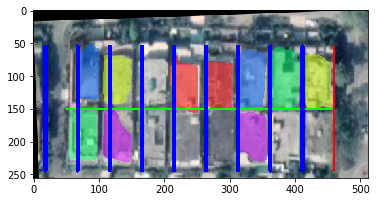

In [34]:
result = skimage.io.imread("./rotated_results/result1.jpg")
result2 = skimage.io.imread("./rotated_results/result1.jpg")
result3 = skimage.io.imread("./rotated_results/result1.jpg")

plt.figure()
plt.imshow(result)

shape = result.shape

a = (50, 150)
b = (460, 150)
cd_length = int(l*2.3)

def distance(p1, p2):
    return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

block_length = distance(a, b)

divisions = int(round(block_length/int(w)))
total_divisions = int(round(divisions))

ab = LineString([a, b])
left = ab.parallel_offset(cd_length / 2, 'left')
right = ab.parallel_offset(cd_length / 2, 'right')

c = left.boundary[1]
d = right.boundary[0]  # note the different orientation for right offset
cd = LineString([c, d])

c = (int(c.x), int(c.y))
d = (int(d.x), int(d.y))

cv2.line(result,a,b,(0,255,0),2)
cv2.line(result,c,d,(255,0,0),2)

cv2.line(result2,a,b,(0,255,0),2)
cv2.line(result2,c,d,(255,0,0),2)

cv2.line(result3,a,b,(0,255,0),2)
cv2.line(result3,c,d,(255,0,0),2)

drawMasks(result, masks)

# testLineCost(result, int(w), c, d, a, masks)
cost = getParallelLinesAndCost(result, int(w), c, d, total_divisions, masks)
print("Cost before line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result)

cost, average_gap = getAdjustedParallelLinesAndCost(result2, int(w), c, d, total_divisions, masks)
print("Cost After line adjustment: ")
print(cost)


plt.figure()
plt.imshow(result2)

cost = getParallelLinesAndCost(result3, int(average_gap), c, d, total_divisions, masks)
print("Cost with average gap: ")
print(cost)

plt.figure()
plt.imshow(result3)



256
512
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  135.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


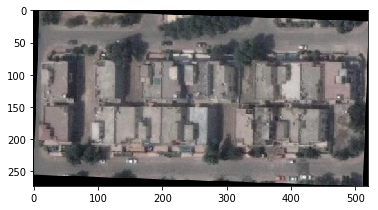

In [36]:
w, l, masks, image = getImageData('block1c', 92)

14
14
Cost before line adjustment: 
135
Cost After line adjustment: 
0
Cost with average gap: 
34


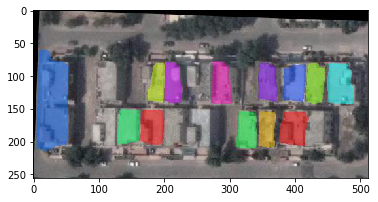

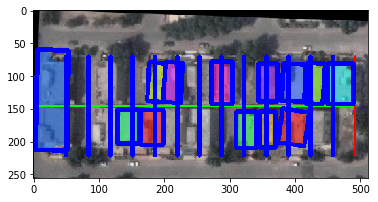

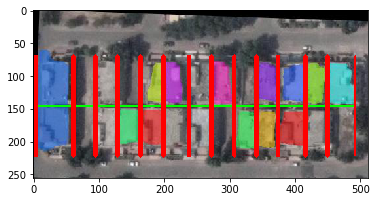

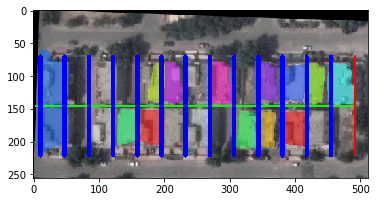

In [37]:
result = skimage.io.imread("./rotated_results/block1c.jpg")
result2 = skimage.io.imread("./rotated_results/block1c.jpg")
result3 = skimage.io.imread("./rotated_results/block1c.jpg")
plt.figure()
plt.imshow(result)

shape = result.shape

a = (3, 146)
b = (492, 146)
cd_length = int(l*2.3)

def distance(p1, p2):
    return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

block_length = distance(a, b)

divisions = int(round(block_length/int(w)))
print(divisions)

total_divisions = int(round(divisions))
print(total_divisions)

ab = LineString([a, b])
left = ab.parallel_offset(cd_length / 2, 'left')
right = ab.parallel_offset(cd_length / 2, 'right')

c = left.boundary[1]
d = right.boundary[0]  # note the different orientation for right offset
cd = LineString([c, d])

c = (int(c.x), int(c.y))
d = (int(d.x), int(d.y))

cv2.line(result,a,b,(0,255,0),2)
cv2.line(result,c,d,(255,0,0),2)

cv2.line(result2,a,b,(0,255,0),2)
cv2.line(result2,c,d,(255,0,0),2)

cv2.line(result3,a,b,(0,255,0),2)
cv2.line(result3,c,d,(255,0,0),2)

drawMasks(result, masks)
cost = getParallelLinesAndCost(result, int(w), c, d, total_divisions, masks)

print("Cost before line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result)

cost, average_gap = getAdjustedParallelLinesAndCost(result2, int(w), c, d, total_divisions, masks)
print("Cost After line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result2)

cost = getParallelLinesAndCost(result3, int(average_gap), c, d, total_divisions, masks)
print("Cost with average gap: ")
print(cost)

plt.figure()
plt.imshow(result3)

256
512
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


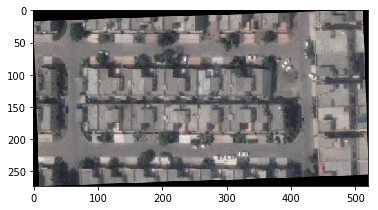

In [170]:
w, l, masks, image = getImageData('block1b', 88)

6
6
Cost before line adjustment: 
123
Cost After line adjustment: 
0


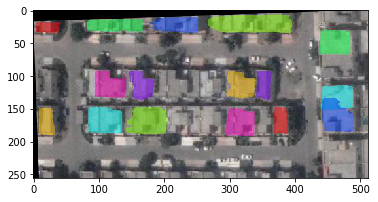

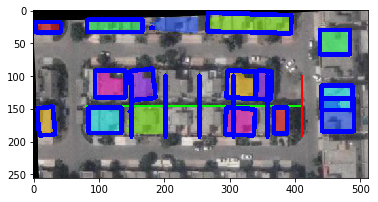

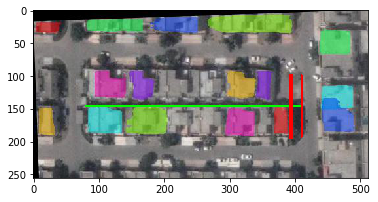

In [171]:
result = skimage.io.imread("./rotated_results/result1b.jpg")
result2 = skimage.io.imread("./rotated_results/result1b.jpg")
plt.figure()
plt.imshow(result)

shape = result.shape

a = (80, 146)
b = (410, 146)
cd_length = int(l*2.5)

def distance(p1, p2):
    return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

block_length = distance(a, b)

divisions = int(round(block_length/int(w)))
print(divisions)

total_divisions = int(round(divisions))
print(total_divisions)

ab = LineString([a, b])
left = ab.parallel_offset(cd_length / 2, 'left')
right = ab.parallel_offset(cd_length / 2, 'right')

c = left.boundary[1]
d = right.boundary[0]  # note the different orientation for right offset
cd = LineString([c, d])

c = (int(c.x), int(c.y))
d = (int(d.x), int(d.y))

cv2.line(result,a,b,(0,255,0),2)
cv2.line(result,c,d,(255,0,0),2)

cv2.line(result2,a,b,(0,255,0),2)
cv2.line(result2,c,d,(255,0,0),2)

drawMasks(result, masks)
cost = getParallelLinesAndCost(result, int(w), c, d, total_divisions, masks)

print("Cost before line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result)

cost = getAdjustedParallelLinesAndCost(result2, int(w), c, d, total_divisions, masks)
print("Cost After line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result2)

768
1024
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  ma

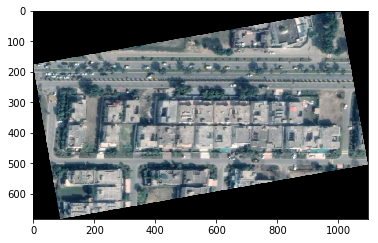

In [163]:
w, l, masks, image = getImageData('block3', -10)

14
14
Cost before line adjustment: 
292
Cost After line adjustment: 
31


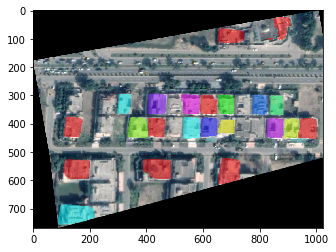

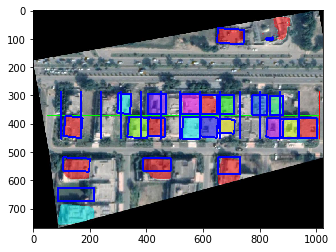

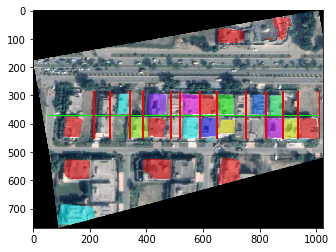

In [169]:
result = skimage.io.imread("./rotated_results/block3.jpg")
result2 = skimage.io.imread("./rotated_results/block3.jpg")
plt.figure()
plt.imshow(result)

shape = result.shape

a = (50, 370)
b = (1010, 370)
cd_length = int(l*2.5)

def distance(p1, p2):
    return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

block_length = distance(a, b)

divisions = int(round(block_length/int(w)))
print(divisions)

total_divisions = int(round(divisions))
print(total_divisions)

ab = LineString([a, b])
left = ab.parallel_offset(cd_length / 2, 'left')
right = ab.parallel_offset(cd_length / 2, 'right')

c = left.boundary[1]
d = right.boundary[0]  # note the different orientation for right offset
cd = LineString([c, d])

c = (int(c.x), int(c.y))
d = (int(d.x), int(d.y))

cv2.line(result,a,b,(0,255,0),2)
cv2.line(result,c,d,(255,0,0),2)

cv2.line(result2,a,b,(0,255,0),2)
cv2.line(result2,c,d,(255,0,0),2)

drawMasks(result, masks)
cost = getParallelLinesAndCost(result, int(w), c, d, total_divisions, masks)

print("Cost before line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result)

cost = getAdjustedParallelLinesAndCost(result2, int(w), c, d, total_divisions, masks)
print("Cost After line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result2)

In [84]:
w, l, masks, image = getImageData('block6e', 78)

AttributeError: 'str' object has no attribute 'shape'

20
20
Cost before line adjustment: 
374
Cost After line adjustment: 
26
Cost with average gap: 
418


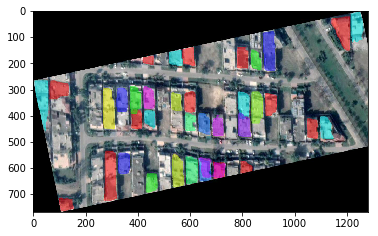

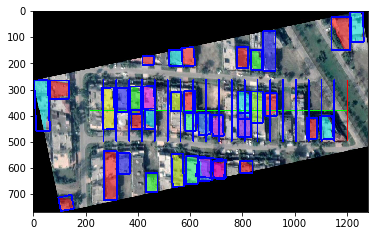

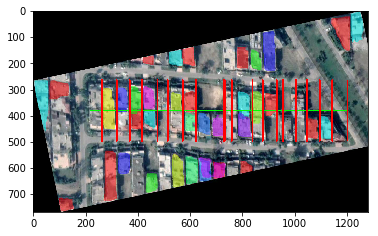

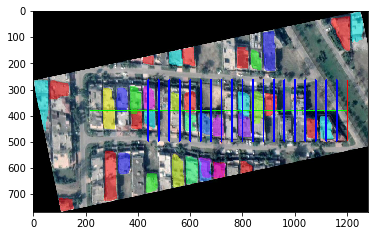

In [68]:
result = skimage.io.imread("./rotated_results/block6e.jpg")
result2 = skimage.io.imread("./rotated_results/block6e.jpg")
result3 = skimage.io.imread("./rotated_results/block6e.jpg")
plt.figure()
plt.imshow(result)

shape = result.shape

a = (220, 380)
b = (1200, 380)

cd_length = int(l*2.5)

def distance(p1, p2):
    return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

block_length = distance(a, b)

divisions = int(round(block_length/int(w)))
print(divisions)

total_divisions = int(round(divisions))
print(total_divisions)

ab = LineString([a, b])
left = ab.parallel_offset(cd_length / 2, 'left')
right = ab.parallel_offset(cd_length / 2, 'right')

c = left.boundary[1]
d = right.boundary[0]  # note the different orientation for right offset
cd = LineString([c, d])

c = (int(c.x), int(c.y))
d = (int(d.x), int(d.y))

cv2.line(result,a,b,(0,255,0),2)
cv2.line(result,c,d,(255,0,0),2)

cv2.line(result2,a,b,(0,255,0),2)
cv2.line(result2,c,d,(255,0,0),2)

cv2.line(result3,a,b,(0,255,0),2)
cv2.line(result3,c,d,(255,0,0),2)

drawMasks(result, masks)
cost = getParallelLinesAndCost(result, int(w), c, d, total_divisions, masks)

print("Cost before line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result)

cost, average_gap = getAdjustedParallelLinesAndCost(result2, int(w), c, d, total_divisions, masks)
print("Cost After line adjustment: ")
print(cost)

plt.figure()
plt.imshow(result2)

cost = getParallelLinesAndCost(result3, int(average_gap), c, d, total_divisions, masks)
print("Cost with average gap: ")
print(cost)

plt.figure()
plt.imshow(result3)

In [13]:
def getAdjustedParallelLinesAndCost(image, w, point1, point2, total_divisions, masks, end_point1):
    cost = 0
    points = []
    
    while(point1[0] > end_point1[0]):
        line_point1 = list(point1)
        new_1 = line_point1[0] - w

        line_point2 = list(point2)
        new_2 = line_point2[0] - w

        line_point1[0] = new_1
        line_point2[0] = new_2
        
        if line_point1[0] <= end_point1[0]:
            break

        line_point1 = tuple(line_point1)
        line_point2 = tuple(line_point2)
        
        new_point1, new_point2 = getAdjustedLineCoordinates(line_point1, line_point2, masks)
        
        cv2.line(image,new_point1,new_point2,(255,0,0),5)
        
        c = calculateLineCost(new_point1, new_point2, masks)
        cost += c

        point1 = line_point1
        point2 = line_point2
        
        points.append(new_point1[0])
        
    return cost, points

In [14]:
def drawMasks(img, masks):
    for m in masks:
        cv2.drawContours(img,[m],0,(0,0,255),5)

In [15]:
def getParallelLinesAndCost(image, w, start_point1, start_point2, total_divisions, masks, end_point1):
    cost = 0
    print(end_point1[0])
    while(start_point1[0] > end_point1[0]):
#     for i in range(total_divisions - 1):
        start_point1 = list(start_point1)
        new_1 = start_point1[0] - w

        start_point2 = list(start_point2)
        new_2 = start_point2[0] - w
        
        start_point1[0] = new_1
        start_point2[0] = new_2
        
        if start_point1[0] <= end_point1[0]:
            break

        start_point1 = tuple(start_point1)
        start_point2 = tuple(start_point2)

        c = calculateLineCost(start_point1, start_point2, masks)
        cost += c
        
        print(start_point1[0])

        cv2.line(image,start_point1,start_point2,(0,0,255),5)
        
    return cost

In [16]:
def calculateLineCost(a, b, masks):
    cost = 0
    
    for m in masks:
        cost += findIntersections(m, a)
                
    return cost                
        

In [17]:
def findIntersections(m, a):
    cost = 0
    
    #starting point of mask is behind the line
    if m[0][0] < a[0]:
        if m[1][0] < a[0]:
            if (a[0] > m[1][0]) and (a[0] < m[2][0]):
                mid = int((m[2][0] - m[1][0])/2)
                mid = m[1][0] + mid
                
                if a[0] >= mid:
                    cost += m[2][0] - a[0]
                else:
                    cost += a[0] - m[1][0]
                
        else:
            if (a[0] > m[0][0]) and (a[0] < m[1][0]):
                mid = int((m[1][0] - m[0][0])/2)
                mid = m[0][0] + mid
                
                if a[0] >= mid:
                    cost += m[1][0] - a[0]
                else:
                    cost += a[0] - m[0][0]
    # after the line
    else:
        if m[1][0] > a[0]:
            if (a[0] > m[2][0]) and (a[0] < m[1][0]):
                mid = int((m[1][0] - m[2][0])/2)
                mid = m[2][0] + mid
                
                if a[0] >= mid:
                    cost += m[1][0] - a[0]
                else:
                    cost += a[0] - m[2][0]
        else:
            if (a[0] > m[1][0]) and (a[0] < m[0][0]):
                mid = int((m[0][0] - m[1][0])/2)
                mid = m[1][0] + mid
                
                if a[0] >= mid:
                    cost += m[0][0] - a[0]
                else:
                    cost += a[0] - m[1][0]
                
    
    return cost

In [18]:
def getAdjustedLineCoordinates(a, b, masks):
    
    a = list(a)
    b = list(b)
    
    for m in masks:
        #starting point of mask is behind the line
        if m[0][0] < a[0]:
            if m[1][0] < a[0]:
                if (a[0] > m[1][0]) and (a[0] < m[2][0]):
                    mid = int((m[2][0] - m[1][0])/2)
                    mid = m[1][0] + mid

                    if a[0] >= mid:
                        a[0] = m[2][0]
                        b[0] = m[2][0]
                    else:
                        a[0] = m[1][0]
                        b[0] = m[1][0]

            else:
                if (a[0] > m[0][0]) and (a[0] < m[1][0]):
                    mid = int((m[1][0] - m[0][0])/2)
                    mid = m[0][0] + mid

                    if a[0] >= mid:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                    else:
                        a[0] = m[0][0]
                        b[0] = m[0][0]
                        
        # after the line
        else:
            if m[1][0] > a[0]:
                if (a[0] > m[2][0]) and (a[0] < m[1][0]):
                    mid = int((m[1][0] - m[2][0])/2)
                    mid = m[2][0] + mid

                    if a[0] >= mid:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                    else:
                        a[0] = m[2][0]
                        b[0] = m[2][0]
            else:
                if (a[0] > m[1][0]) and (a[0] < m[0][0]):
                    mid = int((m[0][0] - m[1][0])/2)
                    mid = m[1][0] + mid

                    if a[0] >= mid:
                        a[0] = m[0][0]
                        b[0] = m[0][0]
                    else:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                        
    return tuple(a),tuple(b)

In [19]:
def pointOfInteresection(A, B, C, D):
    
    line1 = LineString([A, B])
    line2 = LineString([C, D])

    int_pt = line1.intersection(line2)
    return int_pt

def 


SyntaxError: invalid syntax (<ipython-input-19-aee05e55b4d2>, line 9)

In [20]:
def estimateGrid(file_name, r_image, w, l, masks, a, b):

    plt.figure()
    plt.imshow(r_image)

    image = skimage.io.imread("./rotated_results/"+file_name+".jpg")
    image2 = skimage.io.imread("./rotated_results/"+file_name+".jpg")
    image3 = skimage.io.imread("./rotated_results/"+file_name+".jpg")
    
    shape = image.shape

    def distance(p1, p2):
        return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

    block_length = distance(a, b)
    total_divisions = int(round(block_length/int(w)))

    cd_length = int(l*2.3)
    
    #get line perpendicular to the dividing line ab

    ab = LineString([a, b])
    left = ab.parallel_offset(cd_length / 2, 'left')
    right = ab.parallel_offset(cd_length / 2, 'right')

    c = left.boundary[1]
    d = right.boundary[0]  

    c = (int(c.x), int(c.y))
    d = (int(d.x), int(d.y))
    
    #get line perpendicular to the dividing line ba
    ba = LineString([b, a])
    left = ba.parallel_offset(cd_length / 2, 'left')
    right = ba.parallel_offset(cd_length / 2, 'right')

    e = left.boundary[1]
    f = right.boundary[0]  

    e = (int(e.x), int(e.y))
    f = (int(f.x), int(f.y))
    
    
    
    #draw lines
    cv2.line(image,a,b,(0,255,0),2)
    cv2.line(image,c,d,(255,0,0),2)
    cv2.line(image,e,f,(255,0,0),2)

    cv2.line(image2,a,b,(0,255,0),2)
    cv2.line(image2,c,d,(255,0,0),2)
    cv2.line(image2,e,f,(255,0,0),2)
    
    cv2.line(image3,a,b,(0,255,0),2)
    cv2.line(image3,c,d,(255,0,0),2)
    cv2.line(image3,e,f,(255,0,0),2)
    
#     #draw all detected masks
#     drawMasks(image, masks)
    
    
    cost = getParallelLinesAndCost(image, int(w), c, d, total_divisions, masks, e)

    print("Cost before line adjustment: ")
    print(cost)

    plt.figure()
    plt.imshow(image)

    cost, points = getAdjustedParallelLinesAndCost(image2, int(w), c, d, total_divisions, masks, e)
    print("Cost After line adjustment: ")
    print(cost)
    
    plt.figure()
    plt.imshow(image2)
    
    #remove close lines and complete grid
    points_length = len(points)
    min_gap = int(0.25*w)
    
    new_points = []
    
    for i in range(points_length):
        if i+1 < points_length:
            diff = abs(points[i] - points[i+1])

            if diff > min_gap:
                x = points[i]
                point1 = (x, c[1])
                point2 = (x, d[1])
                
                new_points.append(x)
                cv2.line(image3,point1,point2,(255,0,0),2)
        else:
            new_points.append(points[i])
    
    
    cv2.line(image3,c,f,(255,0,0),2)
    cv2.line(image3,d,e,(255,0,0),2)
    
    plt.figure()
    plt.imshow(image3)
    
    boxes = []
    
    for x in new_points:
        boxes.append([c, b, (x, b[1]), (x, c[1])])
        boxes.append([b, d, (x, d[1]), (x, b[1])])
    
            
    return boxes

# Evaluation

In [3]:
from pycocotools.coco import COCO

In [4]:
annFile='./annotations/ground_truth_coco.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Author
Sharada Mohanty [sharada.mohanty@epfl.ch](sharada.mohanty@epfl.ch)

In [5]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
building

COCO supercategories: 
building


In [6]:
catIds = coco.getCatIds(catNms=['building'])
imgIds = coco.getImgIds(catIds=catIds );
print(imgIds)
imgIds = coco.getImgIds(imgIds = [1])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

[1]


{'width': 256, 'license': 0, 'date_captured': '', 'height': 512, 'id': 1, 'file_name': 'block1.jpg'}


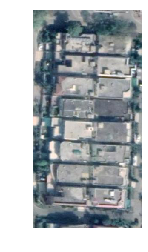

In [10]:
# I = io.imread(img['coco_url'])
print(img)
I = skimage.io.imread(os.path.join(ROOT_DIR, "annotations" ,img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

[155, 60, 81, 48]


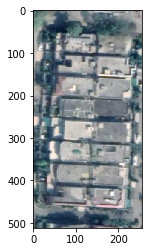

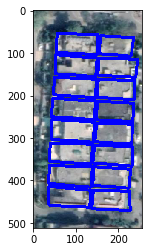

In [11]:
plt.figure()
plt.imshow(I);
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

# print(anns)

mask = coco.annToMask(anns[1])

# print(mask)
# print(mask.shape)
# print(type(mask))
# print(mask.dtype)

mask = anns[1]['segmentation'][0]
print(anns[1]['bbox'])

# [x,y,w,h] = anns[1]['bbox']
# cv2.rectangle(I, (int(x), int(y)), (int(x+w), int(y+h)), (255,0,0), 5)

# side1 = [mask[0],mask[1]]
# side2 = [mask[2], mask[3]]
# side3 = [mask[4], mask[5]]
# side4 = [mask[6], mask[7]]
# box = np.array([side1, side2, side3, side4])
# cv2.drawContours(I,[box],0,(0,255,255),5)



for m in anns:
    mask = m['segmentation'][0]
    side1 = [mask[0],mask[1]]
    side2 = [mask[2], mask[3]]
    side3 = [mask[4], mask[5]]
    side4 = [mask[6], mask[7]]
    box = np.array([side1, side2, side3, side4])
    
    cv2.drawContours(I,[box],0,(0,0,255),5)
    
plt.figure()
plt.imshow(I)

# m = np.full((512, 256), 0, dtype=np.uint8)

# print(m)
# print(m.shape)
# print(type(m))
# print(m.dtype)
# coco.showAnns([anns[0]])

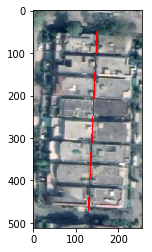

In [27]:
file_name = 'block1'

img_org = skimage.io.imread("./data/test_Data/"+ file_name +".jpg")

a = (150, 50)
b = (130, 470)

cv2.line(img_org,a,b,(255,0,0),2)
plt.imshow(img_org)

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47
426
384
342
300
258
216
174
132
90
48
Cost before line adjustment: 
142
Cost After line adjustment: 
0


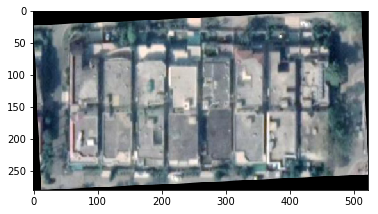

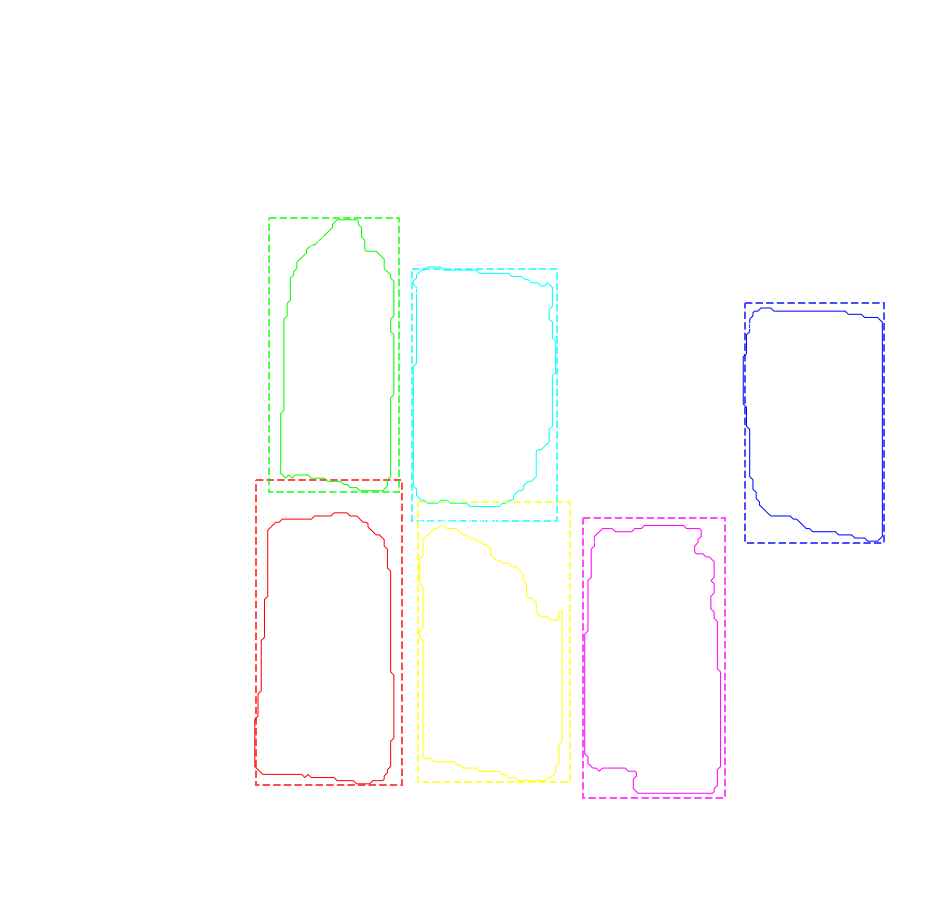

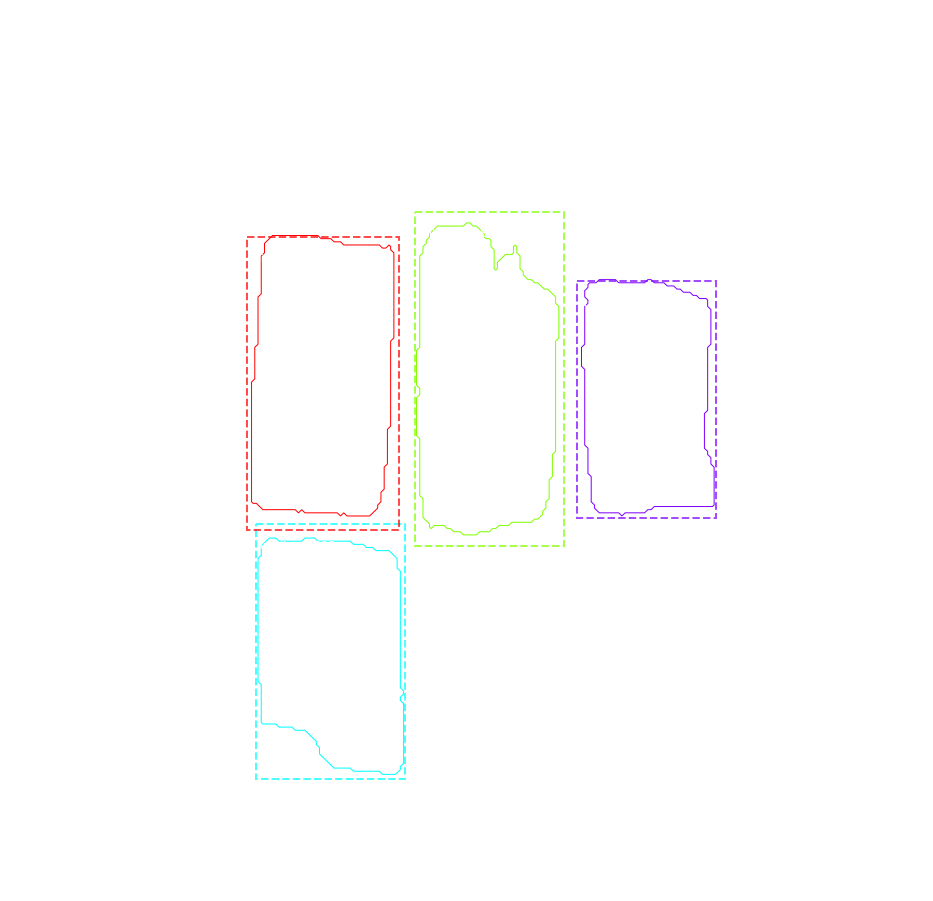

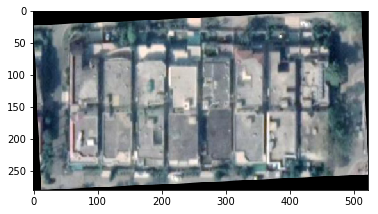

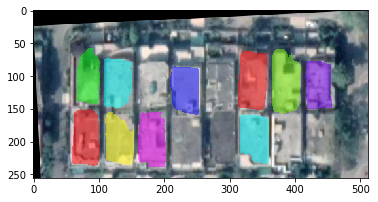

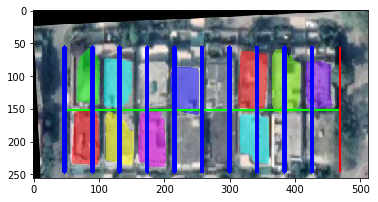

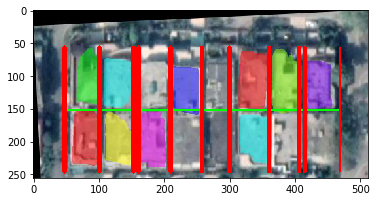

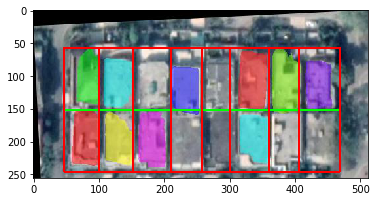

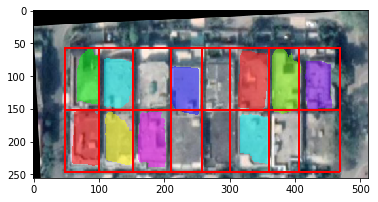

In [28]:
file_name = 'block1'
img_org = skimage.io.imread("./data/test_Data/"+ file_name +".jpg")

a = (130, 470)
b = (150, 50)

r_image, a, b = getRotatedImageAndDividingLine(img_org, a, b)
w, l, masks, r_image = getImageData(r_image, file_name)

boxes = estimateGrid(file_name, r_image, w, l, masks, a, b)

for box in boxes:
    cv2.line(r_image,box[0],box[1],(255,0,0),2)
    cv2.line(r_image,box[1],box[2],(255,0,0),2)
    cv2.line(r_image,box[2],box[3],(255,0,0),2)
    cv2.line(r_image,box[3],box[0],(255,0,0),2)
    
plt.figure()
plt.imshow(r_image)

In [73]:
print(points)

[415, 406, 360, 300, 258, 210, 161, 153, 101, 48]
